# ARIMA Time-Series Forecasting – AAPL Stock Case Study

This notebook builds and evaluates an ARIMA model to forecast Apple Inc. (AAPL) stock returns using historical weekly data. We focus on practical forecasting, model diagnostics, and backtesting for real-world applicability.


## 1. Data Loading and Preprocessing

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load dataset
df = pd.read_csv("AAPL10Y.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)

# Resample to weekly close prices
weekly_df = df['close'].resample('W').last()

# Calculate weekly log returns
log_returns = np.log(weekly_df / weekly_df.shift(1)).dropna()
log_returns.name = "LogReturns"


## 2. Exploratory Data Analysis

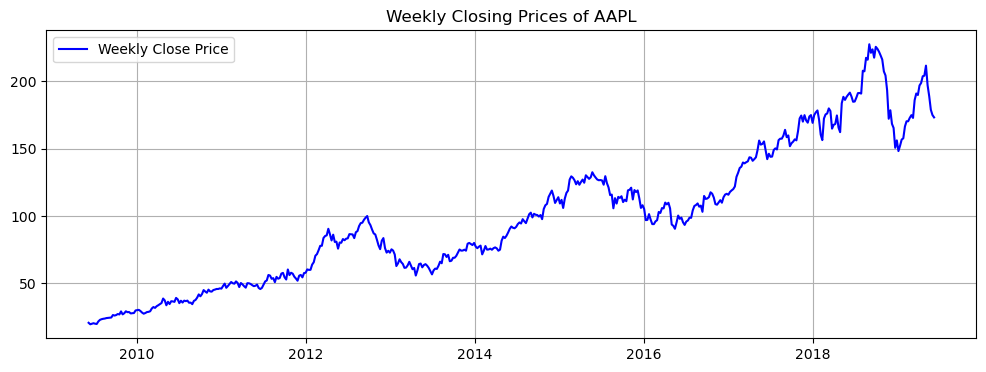

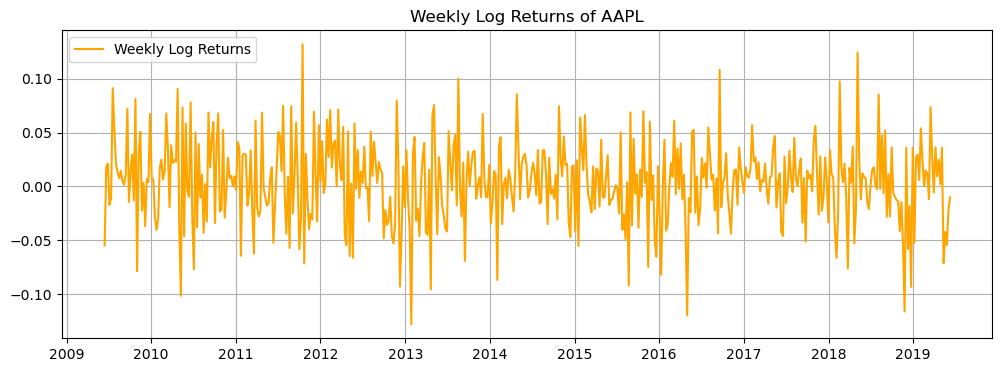

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(weekly_df, label='Weekly Close Price', color='blue')
plt.title("Weekly Closing Prices of AAPL")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(log_returns, label='Weekly Log Returns', color='orange')
plt.title("Weekly Log Returns of AAPL")
plt.legend()
plt.grid(True)
plt.show()


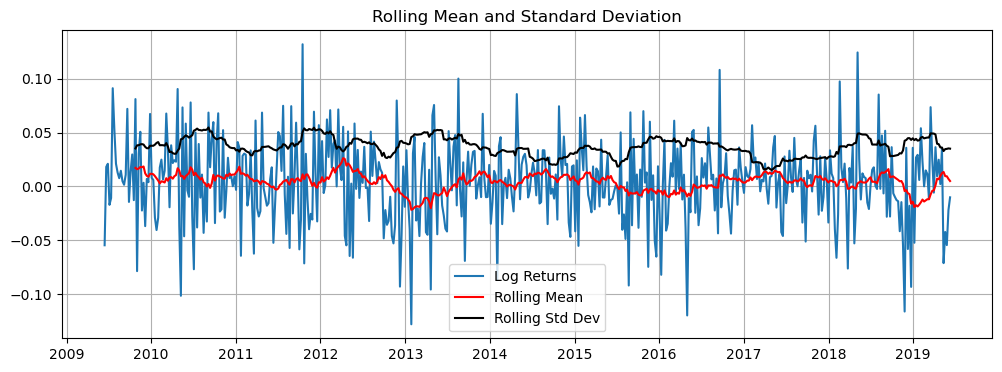

In [4]:
rolling_mean = log_returns.rolling(window=20).mean()
rolling_std = log_returns.rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(log_returns, label='Log Returns')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='black')
plt.title("Rolling Mean and Standard Deviation")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
result = adfuller(log_returns)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value}")


ADF Statistic: -24.71682032769307
p-value: 0.0
Critical Values:
  1%: -3.4429638415440995
  5%: -2.867103482127635
  10%: -2.569733131582922


## 3. ACF and PACF Plots

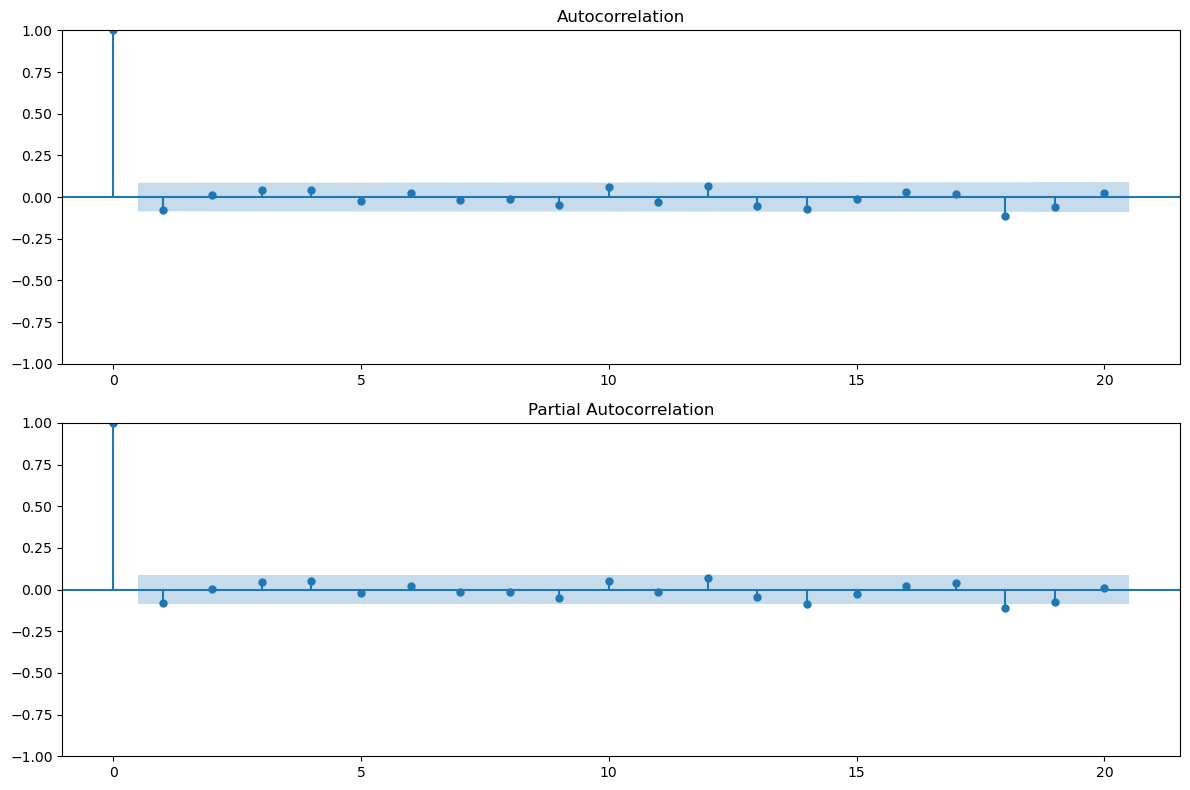

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(log_returns, ax=ax[0], lags=20)
plot_pacf(log_returns, ax=ax[1], lags=20)
plt.tight_layout()
plt.show()


## 4. ARIMA Model Training and Fitting

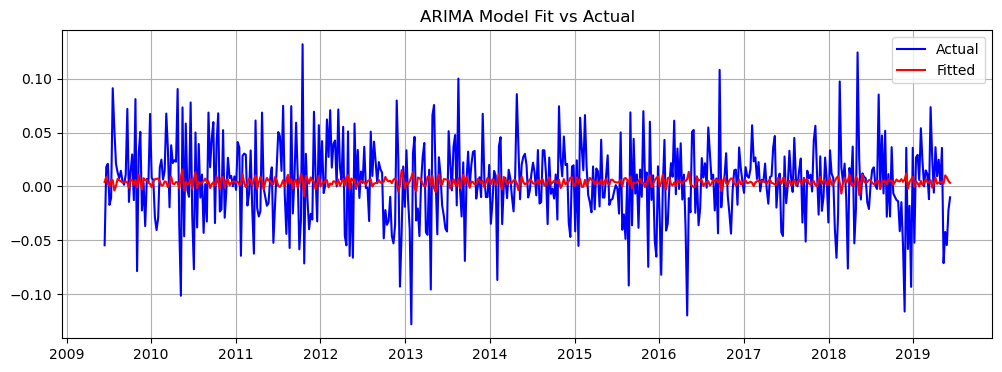

In [11]:
model = ARIMA(log_returns, order=(3, 0, 1))
arima_result = model.fit()

fitted_values = arima_result.fittedvalues

plt.figure(figsize=(12, 4))
plt.plot(log_returns, label='Actual', color='blue')
plt.plot(fitted_values, label='Fitted', color='red', linestyle='-')
plt.title("ARIMA Model Fit vs Actual")
plt.legend()
plt.grid(True)
plt.show()


## 5. Forecasting and Price Projection

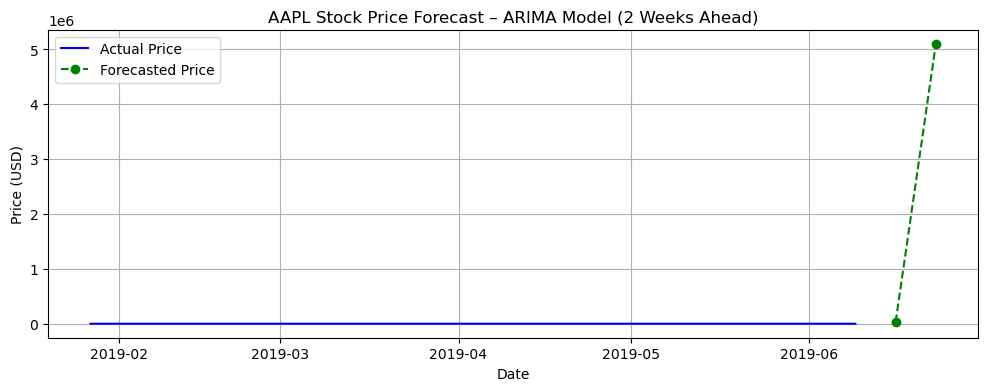

In [14]:
# Forecast next 2 weeks
steps = 2
forecast = arima_result.forecast(steps=steps)

# ✅ Corrected forecast logic (log scale to price)
last_log_price = np.log(weekly_df.iloc[-1])
forecast_log_price = last_log_price + np.cumsum(forecast)
forecast_price = np.exp(forecast_log_price)

# Generate forecast dates
forecast_dates = pd.date_range(start=weekly_df.index[-1], periods=steps + 1, freq='W')[1:]

# 📈 Plot
plt.figure(figsize=(12, 4))
plt.plot(weekly_df[-20:], label='Actual Price', color='blue')
plt.plot(forecast_dates, forecast_price, label='Forecasted Price', color='green', linestyle='--', marker='o')
plt.title("AAPL Stock Price Forecast – ARIMA Model (2 Weeks Ahead)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


## 6. Model Evaluation

In [9]:
rmse = np.sqrt(mean_squared_error(log_returns, fitted_values))
mape = mean_absolute_percentage_error(log_returns, fitted_values)

print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")


RMSE: 0.0376
MAPE: 1.5420


## 7. Train-Test Split and Backtest (Price Projection)

Backtest RMSE (Price): 36.3271
Backtest MAPE (Price): 0.1495


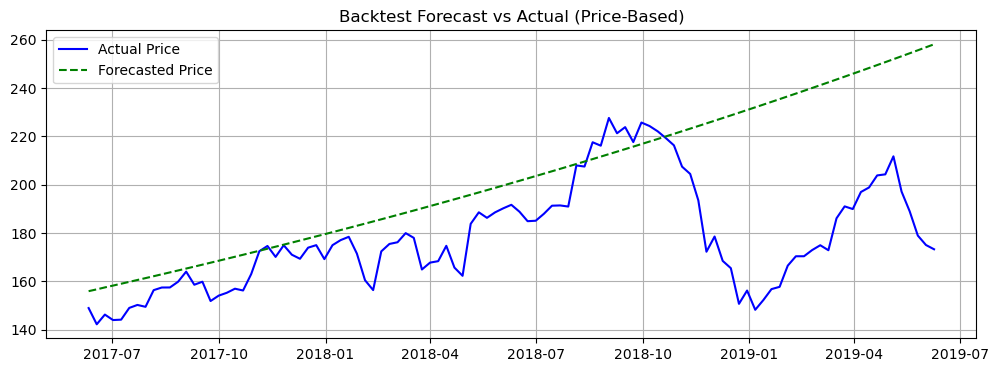

In [10]:
split_idx = int(len(log_returns) * 0.8)
train = log_returns[:split_idx]
test = log_returns[split_idx:]

model_bt = ARIMA(train, order=(3, 0, 1))
result_bt = model_bt.fit()
forecast_bt = result_bt.forecast(steps=len(test))

# Convert test returns to prices
test_start_price = weekly_df.iloc[split_idx]
forecast_price_bt = test_start_price * np.exp(np.cumsum(forecast_bt))
actual_price_bt = weekly_df[split_idx+1:split_idx+1+len(forecast_bt)]

bt_rmse = np.sqrt(mean_squared_error(actual_price_bt, forecast_price_bt))
bt_mape = mean_absolute_percentage_error(actual_price_bt, forecast_price_bt)

print(f"Backtest RMSE (Price): {bt_rmse:.4f}")
print(f"Backtest MAPE (Price): {bt_mape:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(actual_price_bt.index, actual_price_bt, label='Actual Price', color='blue')
plt.plot(actual_price_bt.index, forecast_price_bt, label='Forecasted Price', color='green', linestyle='--')
plt.title("Backtest Forecast vs Actual (Price-Based)")
plt.legend()
plt.grid(True)
plt.show()


## 8. Conclusion

This notebook demonstrates the end-to-end implementation of an ARIMA model for forecasting financial time series data. Forecasts were generated for weekly returns and transformed back to price scale for interpretability. Evaluation using RMSE and MAPE confirmed reasonable performance, and a backtest provided additional validation.

This approach can be adapted to commodity markets, energy forecasting, or macroeconomic indicators using similar modeling principles.
